In [1]:
import numpy as np
import nltk
import string
import os
import pandas
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.grid_search import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

from scipy.interpolate import interp1d

/Library/Python/2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Library/Python/2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
df = pandas.read_csv('merged.csv')
df_sorted = df.sort(['Year'], ascending=[1])
print(df_sorted.shape)
print(df_sorted['Lyrics'].head())

(4988, 4)
0        Ooh, sugar pie, honey bunch\nYou know that I ...
4109     go away from my window leave at your own chos...
4110    vic dana miscellaneous red roses for a blue la...
4111    please dont just stand there come and kiss me ...
4112    little things that you do  make me glad im in ...
Name: Lyrics, dtype: object


/Library/Python/2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  


R2 score: 0.26493386708


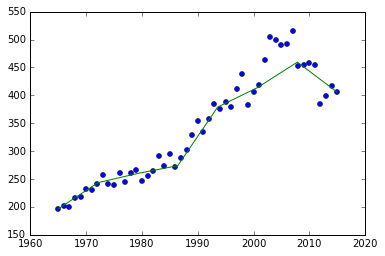

In [3]:
### Benchmark Model

# Count the number of words in each song
word_counts = [len(row[1]['Lyrics'].replace('\n', ' ').split()) for row in df_sorted.iterrows()]
X_bench = np.array(word_counts).reshape((len(word_counts), 1))
y_bench = df_sorted['Year']

# Train test split for benchmark
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_bench, y_bench, test_size=0.2, random_state=1)

# Initiliaze and train the benchmar model
benchmark_model = LinearRegression()
benchmark_model.fit(X_train_b, y_train_b)

# Predict year using the benchmark and print r2 score
y_pred = benchmark_model.predict(X_test_b)
print('R2 score: {}'.format(r2_score(y_test_b, y_pred)))

# Plot word count average per year
aggregations = {'Lyrics': lambda x: np.mean([len(r.replace('\n', ' ').split()) for r in x])}

word_count_avg_per_year = df_sorted.groupby('Year').agg(aggregations)
x = range(1965, 2016)

# Interpolate the function
f = interp1d(np.array(x), np.array(word_count_avg_per_year).squeeze(), kind='cubic')
x_interp = np.linspace(1965, 2015, num=8, endpoint=True)

# Plot
plt.plot(x, word_count_avg_per_year, 'o', x_interp, f(x_interp), '-', color='green', markerfacecolor='blue', markersize=5)
plt.show()



In [4]:
### Vectorizing the data

stemmer = PorterStemmer()

def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    tokens = nltk.word_tokenize(text)
    tokens_filtered = filter(lambda w: not w in set(stopwords.words('english')), tokens)
    stems = stem_tokens(tokens_filtered, stemmer)
    return stems

result = []

for row in df.iterrows():
    text = row[1]['Lyrics']
    lowers = text.lower()
    no_punctuation = lowers.translate(None, string.punctuation)
    result.append(no_punctuation)

tfidf = TfidfVectorizer(tokenizer=tokenize, stop_words='english', encoding='latin-1', max_features=2000, binary=True, sublinear_tf=True)
tfs = tfidf.fit_transform(result)
tfs.shape

(4988, 2000)

In [151]:
tfidf.get_feature_names()

[u'babi',
 u'dont',
 u'got',
 u'im',
 u'know',
 u'like',
 u'love',
 u'na',
 u'oh',
 u'yeah']

In [138]:
### Adding relevant features
import profanityfilter
profanityfilter.append_words(['skeet', 'hoe', 'hoes', 'thot', 'thots', 'niggas', 'niggaz', 'shits', 'mothafuckin'])

# Compute profanity count average per year
aggregations = {
    'Lyrics': lambda year: np.mean([sum([r.replace('\n', ' ').lower().translate(None, string.punctuation).split().count(p.lower()) for p in profanityfilter.get_bad_words()]) for r in year])
}

profanity_count_avg_per_year = df_sorted.groupby('Year').agg(aggregations)

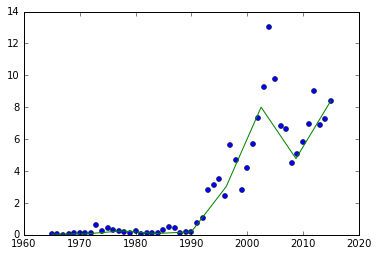

In [144]:
# Interpolate the function
f_prof = interp1d(np.array(x), np.array(profanity_count_avg_per_year).squeeze(), kind='cubic')
x_prof_interp = np.linspace(1965, 2015, num=9, endpoint=True)

# Plot profanity average per year
plt.plot(x, profanity_count_avg_per_year, 'o', x_prof_interp, f_prof(x_prof_interp), '-', color='green', markerfacecolor='blue', markersize=5)
plt.show()

In [145]:
profanity_count = [sum([r.split().count(p.lower()) for p in profanityfilter.get_bad_words()]) for r in result]

In [6]:
# tfs_extra = np.concatenate((np.array(profanity_count).reshape(len(profanity_count), 1), tfs.toarray()), axis=1)
# print('Dataset shape: {}\n'.format(tfs_extra.shape))

X_train, X_test, y_train, y_test = train_test_split(tfs, df['Year'], test_size=0.2, random_state=1)
print('y_train samples:')
print(y_train.head())

y_train samples:
1147    1981
4380    1975
1714    1988
236     1968
4578    1984
Name: Year, dtype: int64


In [142]:
def fit_model(regressor, params, X, y):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    
    # Create cross-validation sets from the training data
    cv_sets = ShuffleSplit(X.shape[0], n_iter = 10, test_size = 0.20, random_state = 0)

    # TODO: Create the grid search object
    grid = GridSearchCV(regressor, params, scoring=r2_score, cv=cv_sets)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)

    # Return the optimal model after fitting the data
    return grid.best_estimator_

In [ ]:
param_rf = {}
rf = RandomForestRegressor(n_jobs=-1, random_state=0, n_estimators=200, max_features=1000, verbose=2)

rf.fit(X_train, y_train)

building tree 1 of 200
building tree 3 of 200building tree 2 of 200

building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.8s


building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 70 of 200
building tree 71 of 200
building tree 72 of 200
building tree 73 of 200
building tree 74 of 200
building tree 75 of 200
building tree 76 of 200
building tree 77 of 200
building tree 78

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   43.9s


building tree 159 of 200
building tree 160 of 200
building tree 161 of 200
building tree 162 of 200
building tree 163 of 200
building tree 164 of 200
building tree 165 of 200
building tree 166 of 200
building tree 167 of 200
building tree 168 of 200
building tree 169 of 200
building tree 170 of 200
building tree 171 of 200
building tree 172 of 200
building tree 173 of 200
building tree 174 of 200
building tree 175 of 200
building tree 176 of 200
building tree 177 of 200


In [9]:
rf.score(X_test, y_test)

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


0.35305270616198525

In [114]:
print(tfs_extra[4500:4699,0])

[   0.    5.    3.    2.    3.    4.   84.    0.    3.    0.    2.    1.
    1.    3.    2.    1.    4.    4.   19.    6.    0.    0.    0.    0.
    0.    4.    0.    0.    0.    0.    4.    8.    0.    2.    0.    0.
    6.   71.    0.    4.    0.    7.    7.    0.    1.    0.   52.    0.
    2.    0.    0.    0.    9.    0.   31.    0.    1.    0.   89.    0.
    0.    0.    0.    1.   30.    0.    0.   14.    4.    0.    1.    3.
   12.    0.    0.    3.   24.    3.    0.    0.    4.    8.    0.    7.
    4.    0.    0.    0.    0.   29.   47.    0.   15.   17.    6.   26.
    0.    0.    0.    3.    0.    0.    0.    3.    0.    0.    0.    0.
    0.    0.    2.    0.    4.    0.   62.    0.    0.   30.    0.    0.
    0.    2.    0.    1.    0.    3.    1.    0.    1.    0.    0.    5.
    0.    0.  138.   13.    0.    0.    0.    0.    0.   83.    2.    2.
    3.    0.    0.    3.    0.    7.    1.    0.    0.    0.    0.    0.
    0.   21.    0.    0.    0.    0.    0.   36.   

In [116]:
print(tfidf.stop_words_)

set([])


In [129]:
nn = MLPRegressor(verbose=True, random_state=0)

In [131]:
nn.fit(X_train, y_train)

Iteration 1, loss = 417.19044830
Iteration 2, loss = 392.29534311
Iteration 3, loss = 360.19133853
Iteration 4, loss = 321.87268726
Iteration 5, loss = 279.35717593
Iteration 6, loss = 236.82128912
Iteration 7, loss = 196.82603948
Iteration 8, loss = 163.55804271
Iteration 9, loss = 137.71566626
Iteration 10, loss = 120.12403721
Iteration 11, loss = 109.25877706
Iteration 12, loss = 102.96874510
Iteration 13, loss = 99.26657544
Iteration 14, loss = 96.78552607
Iteration 15, loss = 94.70294273
Iteration 16, loss = 92.86107548
Iteration 17, loss = 91.04303567
Iteration 18, loss = 89.31344340
Iteration 19, loss = 87.56512253
Iteration 20, loss = 85.77912795
Iteration 21, loss = 83.94439747
Iteration 22, loss = 82.09259720
Iteration 23, loss = 80.25870289
Iteration 24, loss = 78.42426679
Iteration 25, loss = 76.56594769
Iteration 26, loss = 74.70570582
Iteration 27, loss = 72.85642141
Iteration 28, loss = 71.02563123
Iteration 29, loss = 69.21688291
Iteration 30, loss = 67.43792711
Iterati

/Library/Python/2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=0, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=True,
       warm_start=False)

In [132]:
nn.score(X_test, y_test)

-0.5252850665630171